In [1]:
from sklearn.model_selection import train_test_split

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import torch

%matplotlib inline

# Let's inspect the data

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# Description of the columns from [OpenML](https://www.openml.org/d/42079)
* Id: Unique ID for each home sold
* Date: Date of the home sale
* Price: Price of each home sold
* Bedrooms: Number of bedrooms
* Bathrooms: Number of bathrooms, where .5 accounts for a room with a toilet but no shower
* Sqft_living: Square footage of the apartments interior living space
* Sqft_lot: Square footage of the land space
* Floors: Number of floors
* Waterfront: A dummy variable for whether the apartment was overlooking the waterfront or not
* View: An index from 0 to 4 of how good the view of the property was
* Condition: An index from 1 to 5 on the condition of the apartment
* Grade: An index from 1 to 13, where 1-3 falls short of the building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design
* Sqft_above: The square footage of the interior housing space that is above ground level.
* Sqft_basement: The square footage of the interior housing space that is below ground level.
* Yr_built: The year the house was initially built
* Yr_renovated: The year of the house's last renovation
* Zipcode: What zipcode area the house is in
* Lat: Lattitude
* Long: Longitude
* Sqft_living15: The square footage of interior housing living space for the nearest 15 neighbors.
* Sqft_lot15: The square footage of the land lots of the nearest 15 neighbors.

Id and zipcode are useless.  
Date looks dangarous, as we want our model to predict future house prices. Two solutions look reasonable here: drop date, or sort the data by date and select test and validation subset as last rows.

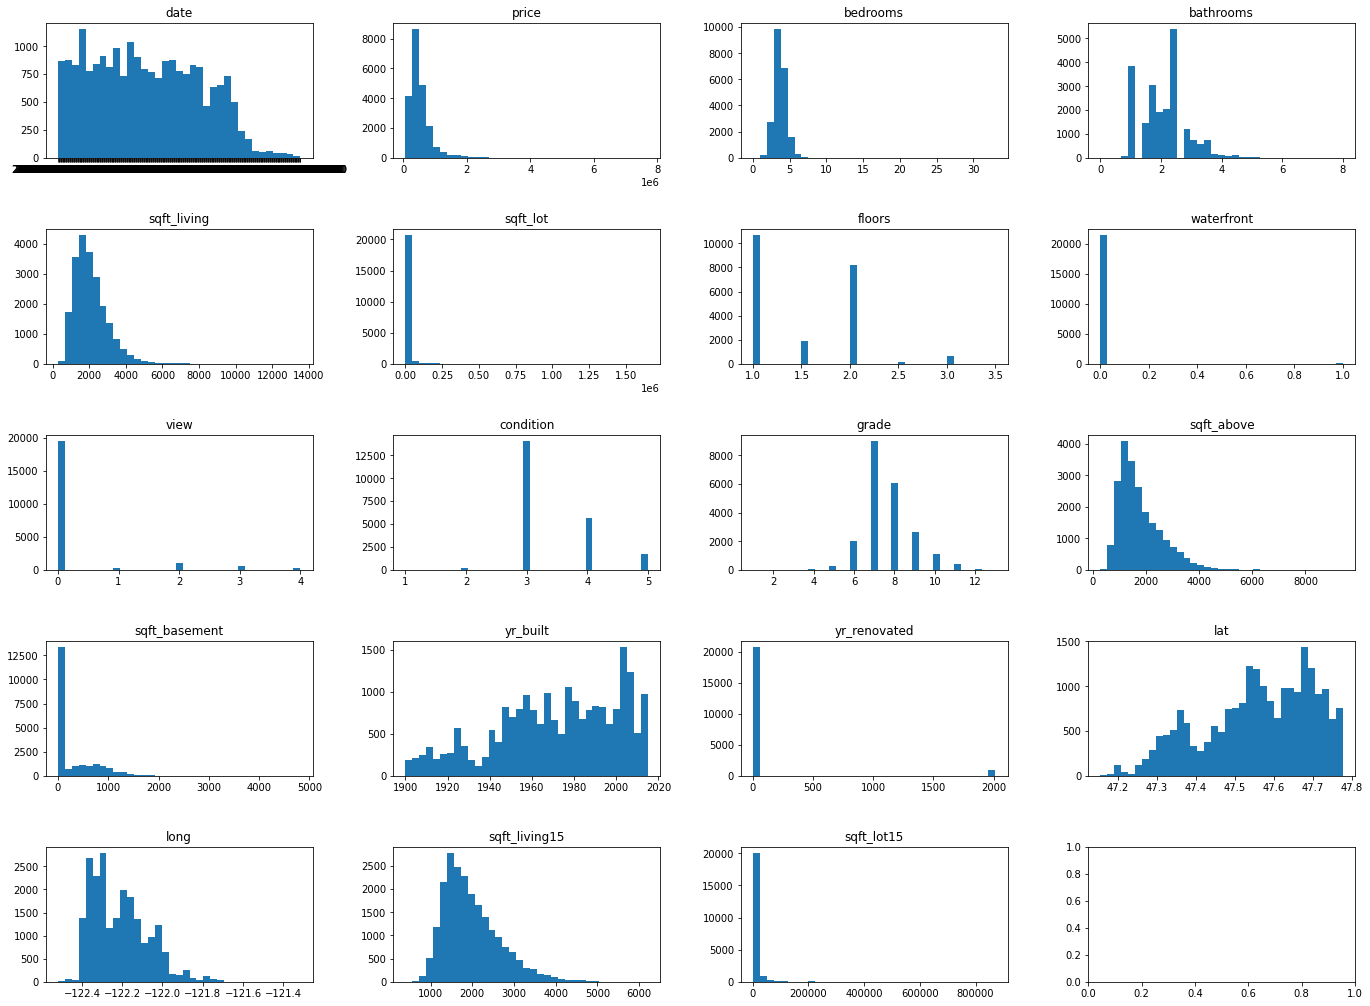

In [3]:
plt.rcParams['figure.figsize'] = [20, 15]


def plot_numerical_data(df, columns):
    n_bins = 35
    plt_rows, plt_columns = math.ceil(len(columns) / 4), 4
    fig, axs = plt.subplots(plt_rows, plt_columns)
    fig.tight_layout(pad=5.0)
    curr_row_id, curr_col_id = 0, 0
    for column_name in columns:
        axs[curr_row_id, curr_col_id].hist(df[column_name], bins=n_bins)
        axs[curr_row_id, curr_col_id].set_title(column_name)
        curr_col_id += 1
        if curr_col_id == plt_columns:
            curr_row_id += 1
            curr_col_id = 0

df_without_useless = df.drop(columns=['id', 'zipcode'])
plot_numerical_data(df_without_useless, df_without_useless.columns)

In [4]:
df_clean = df_without_useless.drop(columns=['date'])
X, y = df_clean.drop(columns=['price']), df_clean['price']

In [194]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.2, random_state=2)

In [6]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(12103, 17) (12103,)
(3026, 17) (3026,)
(6484, 17) (6484,)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = Pipeline(steps=[('scaler', MinMaxScaler())])

# Hyperparameter tuning for different models

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## Random forest

In [14]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 40, cv = 3, verbose=3, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto'],
                                        'n_estimators': [10, 50, 91, 131, 172,
                                                         213, 253, 294, 334,
                                                         375, 416, 456, 497,
                                                         537, 578, 619, 659,
                                                         700, 741, 781, 822,
                                                         862, 903, 944, 984,
                                                         1025, 1065, 1106, 1147,
     

In [21]:
means = rf_random.cv_results_['mean_test_score']
stds = rf_random.cv_results_['std_test_score']
params = rf_random.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

print(f'BEST params: {rf_random.best_params_}')

-32472790517.292767 (3277271330.7498426) with: {'n_estimators': 1147, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
-32558239068.03197 (3219697999.0388827) with: {'n_estimators': 619, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}
-17127312369.155848 (2236327054.070669) with: {'n_estimators': 50, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
-16660988817.277054 (2315938867.689412) with: {'n_estimators': 1593, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
-16808341479.940948 (2291361107.3896317) with: {'n_estimators': 334, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
-32482097544.83045 (3227292874.9718843) with: {'n_estimators': 822, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}
-16680725521.44998 (2263470874.445715) with: {'n_estimators': 944, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}
-32517346774.355022 (3277849834.6847143) with: {'n_estimators': 984, 'max_features': 'auto', 'ma

In [9]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 15, 30, 70, 90, 120],
    'max_features': ['auto'],
    'n_estimators': [1000, 1500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 3, verbose = 3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [5, 15, 30, 70, 90, 120],
                         'max_features': ['auto'],
                         'n_estimators': [1000, 1500]},
             scoring='neg_mean_squared_error', verbose=3)

In [ ]:
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

print(f'BEST params: {grid_search.best_params_}')

# -27752990063.2683 (3269224672.841405) with: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1000}
# -27817304314.52292 (3281872392.8639107) with: {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1500}
# -16693320804.604544 (2261558055.7450924) with: {'bootstrap': True, 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 1000}
# -16764377960.02912 (2413088769.7724075) with: {'bootstrap': True, 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 1500}
# -16714326253.100683 (2376138092.143213) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}
# -16708114174.715601 (2311780574.918468) with: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1500}
# -16700103446.085402 (2408440605.4063125) with: {'bootstrap': True, 'max_depth': 70, 'max_features': 'auto', 'n_estimators': 1000}
# -16755953288.657745 (2357796480.497174) with: {'bootstrap': True, 'max_depth': 70, 'max_features': 'auto', 'n_estimators': 1500}
# -16740460165.251938 (2362327936.3857937) with: {'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'n_estimators': 1000}
# -16759619528.1844 (2408687254.268915) with: {'bootstrap': True, 'max_depth': 90, 'max_features': 'auto', 'n_estimators': 1500}
# -16656088343.982292 (2278032981.0243497) with: {'bootstrap': True, 'max_depth': 120, 'max_features': 'auto', 'n_estimators': 1000}
# -16757204055.316446 (2342651965.1290975) with: {'bootstrap': True, 'max_depth': 120, 'max_features': 'auto', 'n_estimators': 1500}
# BEST params: {'bootstrap': True, 'max_depth': 120, 'max_features': 'auto', 'n_estimators': 1000}

## XGBoost

In [17]:
from xgboost import XGBRegressor

parameters = {'nthread':[12],
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [3, 4, 5, 6, 8],
              'min_child_weight': [1, 3, 5, 7],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [5, 50, 500],
              'verbosity': [0]}

xgb = XGBRegressor()
grid_search = GridSearchCV(xgb, parameters, scoring="neg_mean_squared_error", n_jobs=1, cv=3)
grid_result = grid_search.fit(X_train.to_numpy(), y_train.to_numpy())

In [19]:
print(f'BEST params: {grid_search.best_params_}')

BEST params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 12, 'objective': 'reg:squarederror', 'subsample': 0.7, 'verbosity': 0}


In [40]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
X_train_t = torch.from_numpy(scaler.fit_transform(X_train.to_numpy())).to(torch.float32).to(device)
y_train_t = torch.from_numpy(y_train.to_numpy()).to(torch.float32).to(device)
X_val_t = torch.from_numpy(scaler.fit_transform(X_val.to_numpy())).to(torch.float32).to(device)
y_val_t = torch.from_numpy(y_val.to_numpy()).to(torch.float32).to(device)

In [76]:
X_train_t

tensor([[0.0606, 0.1481, 0.0659,  ..., 0.1987, 0.2413, 0.0055],
        [0.0909, 0.4074, 0.2689,  ..., 0.3375, 0.4027, 0.0085],
        [0.0909, 0.2593, 0.0983,  ..., 0.2369, 0.1690, 0.0048],
        ...,
        [0.0909, 0.1481, 0.0842,  ..., 0.1771, 0.1467, 0.0080],
        [0.1212, 0.4074, 0.2063,  ..., 0.3242, 0.2970, 0.0076],
        [0.0303, 0.1481, 0.0184,  ..., 0.1496, 0.1300, 0.0100]],
       device='cuda:0')

In [77]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=12103)
val_loader = DataLoader(val_dataset, batch_size=12103)

In [147]:
class FullyConnected(nn.Module):
    def __init__(self):
        super(FullyConnected, self).__init__()
        
        self.fc1 = nn.Sequential(
            nn.Linear(17, 100),
            nn.Dropout(0.7),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(100, 500),
            nn.Dropout(0.7),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(500, 1000),
            nn.Dropout(0.7),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1000, 300),
            nn.Dropout(0.7),
            nn.ReLU()
        )

        self.fc5 = nn.Sequential(
            nn.Linear(300, 1),
        )

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)

        return x

In [148]:
import time

def log_values(key, value):
    hist_run[key].append(value.detach().item())

def train_and_evaluate_model(
        model,
        criterion,
        optimizer,
        train_loader,
        train_set,
        val_loader,
        val_set,
        device,
        num_epochs=10,
        save_every_nth_all=5,
        save_every_nth_batch_loss=50
):
    try:
        for epoch in range(num_epochs):
            if epoch % save_every_nth_all == 0:
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))
                print('-' * 10)
            epoch_start = time.time()
            

            # training phase
            model.train()

            running_loss_train = 0.0
            running_corrects_train = 0.0

            i = 0

            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()

                optimizer.step()

                running_loss_train += loss.detach()

                if i % save_every_nth_batch_loss == 0:
                    log_values('train/batch_loss', loss)

                i += 1
            
            if epoch % save_every_nth_all == 0:
                epoch_loss_train = running_loss_train / len(train_set)
                log_values('train/loss', epoch_loss_train)
                print(f'[TRAIN] loss: {epoch_loss_train}')
            # exit()

            # evaluating phase
            model.eval()

            running_loss_val = 0.0

            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_val += loss.detach()
            
            if epoch % save_every_nth_all == 0:
                epoch_loss_test = running_loss_val / len(val_set)
                log_values('validation/loss', epoch_loss_test)
                print(f'[TEST] loss: {epoch_loss_test}')


                epoch_end = time.time()
                print(f"Epoch elapsed time = {epoch_end - epoch_start}\n")

    except KeyboardInterrupt:
        print('Interrupt')
        pass

    return hist_run

In [149]:
def plot_training(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["train/loss"])) + 1
    ax.plot(x, run_hist["train/loss"], 'b', marker='.', label="epoch train loss")
    ax.plot(x, run_hist["validation/loss"], 'r', marker='.', label="epoch test loss")
    ax.legend()

    fig, ax = plt.subplots(1, 1, figsize=(20, 6), sharex=True)
    x = np.arange(len(run_hist["train/batch_loss"])) + 1
    ax.plot(x, run_hist["train/batch_loss"], 'b', marker='.', label="batch train loss")
    ax.legend()


In [152]:
model = FullyConnected().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

tracked_values = ['train/loss',
                  'train/acc',
                  'validation/loss',
                  'validation/acc',
                  'train/batch_loss']

hist_run = {key: [] for key in tracked_values}


hist = train_and_evaluate_model(model, criterion, optimizer,
                                train_loader, train_dataset,
                                val_loader, val_dataset,
                                device, num_epochs=150)

Epoch 1/150
----------
[TRAIN] loss: 34057760.0


/home/mniedziolka/Projects/University/interpretable-ml/house-sales/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12103])) that is different to the input size (torch.Size([12103, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/mniedziolka/Projects/University/interpretable-ml/house-sales/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([3026])) that is different to the input size (torch.Size([3026, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[TEST] loss: 140426352.0
Epoch elapsed time = 0.21273064613342285

Epoch 6/150
----------
[TRAIN] loss: 34057468.0
[TEST] loss: 140425184.0
Epoch elapsed time = 0.07638812065124512

Epoch 11/150
----------
[TRAIN] loss: 34055908.0
[TEST] loss: 140418224.0
Epoch elapsed time = 0.0768277645111084

Epoch 16/150
----------
[TRAIN] loss: 34050324.0
[TEST] loss: 140391920.0
Epoch elapsed time = 0.07749748229980469

Epoch 21/150
----------
[TRAIN] loss: 34034112.0
[TEST] loss: 140313248.0
Epoch elapsed time = 0.0775918960571289

Epoch 26/150
----------
[TRAIN] loss: 33992940.0
[TEST] loss: 140111136.0
Epoch elapsed time = 0.20025324821472168

Epoch 31/150
----------
[TRAIN] loss: 33896496.0
[TEST] loss: 139645488.0
Epoch elapsed time = 0.07698488235473633

Epoch 36/150
----------
[TRAIN] loss: 33692812.0
[TEST] loss: 138657280.0
Epoch elapsed time = 0.19903802871704102

Epoch 41/150
----------
[TRAIN] loss: 33278740.0
[TEST] loss: 136698160.0
Epoch elapsed time = 0.07694745063781738

Epoch 46

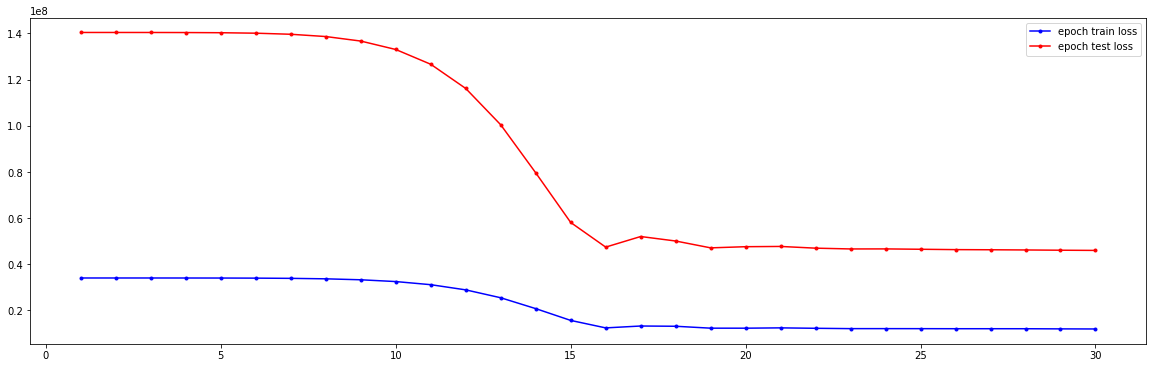

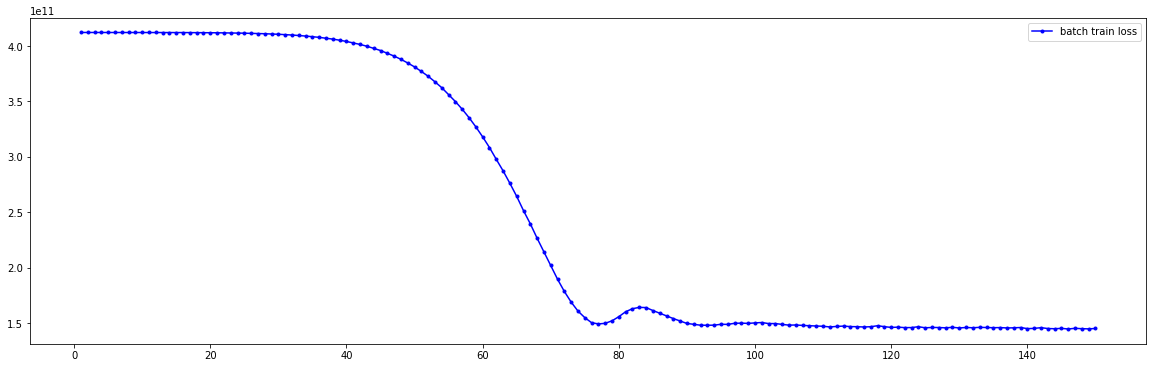

In [153]:
plot_training(hist_run)

# Compare models on validation set

In [99]:
rf = RandomForestRegressor(bootstrap=True, max_depth=120, max_features='auto', n_estimators=1000)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=120, n_estimators=1000)

In [188]:
from sklearn.metrics import mean_absolute_error

rf_p = rf.predict(X_val)
rf_err = mean_absolute_error(y_val, rf_p)

In [107]:
xgb = XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, nthread=12, objective='reg:squarederror', subsample=0.7, verbosity=0)
xgb.fit(X_train.to_numpy(), y_train.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12, nthread=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [187]:
xgb_p = xgb.predict(X_val.to_numpy())

xgb_err = mean_absolute_error(y_val, xgb_p)

In [191]:
with torch.no_grad():
    model.eval()
    p = model(X_val_t).cpu().detach().numpy()
    nn_err = mean_absolute_error(y_val, p)

<BarContainer object of 3 artists>

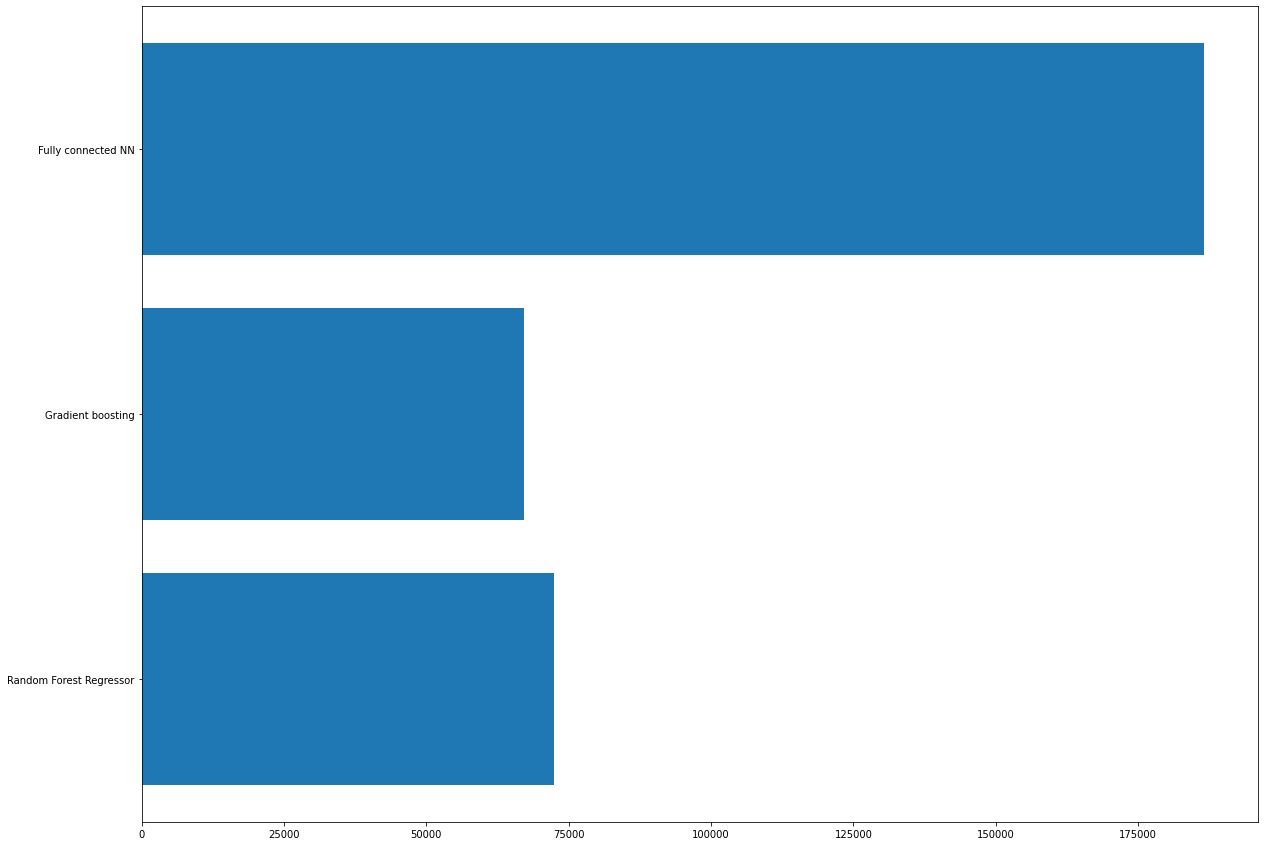

In [193]:
scores = pd.DataFrame({'Models': ['Random Forest Regressor', 'Gradient boosting', 'Fully connected NN'], 'Mean absolute errors': [rf_err, xgb_err, nn_err]})
plt.barh(scores['Models'], scores['Mean absolute errors'])


# Let's find out final error

In [195]:
xgb_final = XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, nthread=12, objective='reg:squarederror', subsample=0.7, verbosity=0)
xgb.fit(X_train_and_val.to_numpy(), y_train_and_val.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=12, nthread=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [197]:
xgb_p = xgb.predict(X_test.to_numpy())

xgb_err = mean_absolute_error(y_test, xgb_p)
print(f"Mean absolute error on test set = {xgb_err}")

Mean absolute error on test set = 66126.41487339027
